In [1040]:
import numpy as np
import matplotlib.pyplot as plt
import time

Feed forward

In [636]:
inputs = np.eye(5)
targets = np.random.rand(len(inputs),8)

weights = []
weights.append(np.random.rand(len(inputs[0]), 7))
weights.append(np.random.rand(len(weights[-1][0]), 9))
weights.append(np.random.rand(len(weights[-1][0]), 6))
weights.append(np.random.rand(len(weights[-1][0]), len(targets[0])))

lr = 0.025

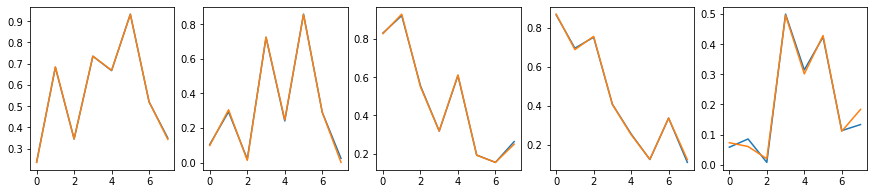

In [653]:
for _ in range(10000):
    g = inputs @ weights[0]
    g2 = g @ weights[1]
    g3 = g2 @ weights[2]
    g4 = g3 @ weights[3]

    u = np.sum([np.outer(inputs[n],(((g4-targets)[n] @ weights[3].T) @ weights[2].T) @ weights[1].T) for n in range(len(inputs))],0)*lr
    u2 = np.sum([np.outer(g[n],((g4-targets)[n] @ weights[3].T) @ weights[2].T) for n in range(len(inputs))],0)*lr
    u3 = np.sum([np.outer(g2[n],(g4-targets)[n] @ weights[3].T) for n in range(len(inputs))],0)*lr
    u4 = np.sum([np.outer(g3[n],(g4-targets)[n]) for n in range(len(inputs))],0)*lr

    weights[0] = weights[0] - u*lr
    weights[1] = weights[1] - u2*lr
    weights[2] = weights[2] - u3*lr
    weights[3] = weights[3] - u4*lr

fig, axs = plt.subplots(1,len(inputs), figsize=(3*len(inputs), 3))
for index,item in enumerate(axs):
    item.plot(np.array([((((inputs @ weights[0]) @ weights[1]) @ weights[2]) @ weights[3])[index],targets[index]]).T)

recurrent

In [1071]:
data = np.array([0.2,0.3,0.7,0.7,0.5,0.1,0.4,0.2,0.3,0.6,0.3])
inputs = [[0.1 for n in range(len(data)-1)]]
for n in data[:-1]:
    inputs.append(inputs[-1][1:]+[n])

targets = data.reshape(len(data),1)

wbb = np.random.rand(1, 1)
wab = np.random.rand(1, 1)
wbc = np.random.rand(1, 1)

lr = 0.1

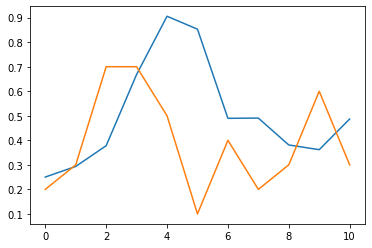

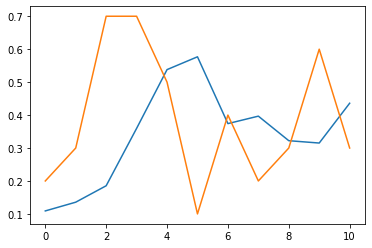

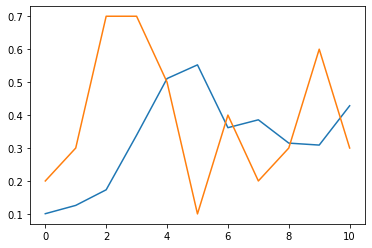

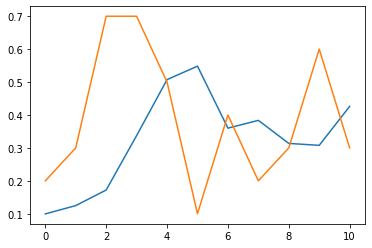

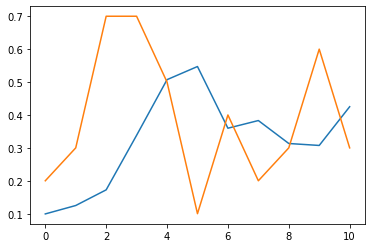

<Figure size 432x288 with 0 Axes>

In [1072]:
for _ in range(5):
    outputs = np.zeros(len(data))
    for index,_ in enumerate(outputs):
        rollout = [(np.zeros(1) @ wbb) + (inputs[index][0:1] @ wab)]
        for n in range(1,len(inputs[index])):
            rollout.append((rollout[-1] @ wbb) + (inputs[index][n:n+1] @ wab))
        outputs[index] = rollout[-1] @ wbc

        ubb = np.outer(rollout[-3],((outputs[index]-targets[index]) @ wbc.T) @ wbb.T)
        uab = np.outer(inputs[index][-2],((outputs[index]-targets[index]) @ wbc.T) @ wbb.T)
        ubc = np.outer(rollout[-1],(outputs[index]-targets[index]))

        wbc = wbc - ubc*lr
        wab = wab - uab*lr
        wbb = wbb - ubb*lr

    plt.plot(np.array([outputs,targets.reshape((len(targets)))]).T)
    plt.show()
    plt.clf()
    time.sleep(1)